# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Цветков Виталий Сергеевич`

Группа: `DS-11`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [1]:
import geopandas as gpd
import folium
from random import uniform
import time
from shapely import geometry, wkt
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiPolygon

from folium.plugins import TimestampedGeoJson

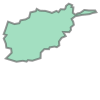

In [2]:
#get Afghanistan polygon
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
afghanistan = world[world['name'] == 'Afghanistan']['geometry'][103]
afghanistan

In [3]:
#center of afghanistan
afg_pt = afghanistan.centroid
afg_pt.within(afghanistan)

True

In [4]:
route = []
# first random point (limits: whole world)
point = Point(uniform(-90, 90), uniform(-180,180))
i = 0
t = int(time.time())
route.append({'coords': [point.x, point.y],
             'times': t})
while not (point.within(afghanistan)):
    # line between AFG and point
    line = LineString([point, afg_pt])
    # new random point on the line
    point = line.interpolate(uniform(0,0.1), normalized=True)
    t += int(1e7)
    route.append({
        'coords': [point.x, point.y],
        'times': t
    })
    i += 1
    print(i, 'step.', point.wkt)

1 step. POINT (-36.48940318276351 79.84711636963338)
2 step. POINT (-35.25796371981475 79.29499177537764)
3 step. POINT (-26.27184545172475 75.26600208324713)
4 step. POINT (-22.83169584995288 73.72358667412168)
5 step. POINT (-20.23458335180364 72.5591529139403)
6 step. POINT (-14.58014974171905 70.02394760613063)
7 step. POINT (-13.9588781355734 69.74539608672066)
8 step. POINT (-11.05738426404012 68.44449078462829)
9 step. POINT (-5.077018282545344 65.76315139249364)
10 step. POINT (-4.241824948102226 65.38868655294701)
11 step. POINT (0.5251801448373161 63.25136609835329)
12 step. POINT (5.499484363216221 61.02110161446176)
13 step. POINT (9.276122883303605 59.32781901853068)
14 step. POINT (12.91451499008836 57.696520179941)
15 step. POINT (18.12501152218066 55.36035720140235)
16 step. POINT (19.40325593403669 54.78724727721191)
17 step. POINT (23.92410405347272 52.76029304297091)
18 step. POINT (24.07330595539144 52.6933973148108)
19 step. POINT (25.23983076660464 52.170377663858

In [5]:
# GeoJSON style function
def style_function(color):
    return lambda feature: dict(color=color,
                              weight=5,
                              opacity=0.75)
features = [
      {
        'type': 'Feature',
        'geometry': {
          'type': 'Point',
          'coordinates': r['coords']
          },
        'properties': {
            'times': [r['times']],
            'icon':'circle',
            'iconstyle': {
                'fillColor': 'black',
                'fillOpacity': 0.6,
                'radius': 7
            }
          }
        }
      for r in route
]
m = folium.Map(min_zoom=2)
# mark afghanistan on the map
folium.features.GeoJson(data=afghanistan,
                        style_function=style_function('#FF0000'),
                        overlay=True).add_to(m)
# add generated points
TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features
},
duration='PT50H'
).add_to(m)
m

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [6]:
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from OSMPythonTools.nominatim import Nominatim

from rtree import index
from math import radians
from sklearn.metrics.pairwise import haversine_distances

In [7]:
# objects for API
nominatim = Nominatim()
overpass = Overpass()

# this will be the answer
dist_sum = 0

In [13]:
# function for calculating distances
def haversine(p1, p2):
    # take radians
    p1_rad = [radians(_) for _ in p1]
    p2_rad = [radians(_) for _ in p2]
    # multiply by Earth radius to get kilometers
    return (haversine_distances([p1_rad, p2_rad]) * 6371000/1000)[0][1]

### 2.1

In [8]:
#select all countries from OSM
countries = overpass.query('relation["admin_level"="2"][boundary=administrative];out;')

In [9]:
%%time
# find country with the greatest number of residential buildings (out of countries with area id % 10)
target_countries = []
best_country = ['', 0]
for el in countries.elements():
    curr = nominatim.query(el.tag('name:en'))
    if (curr.areaId() is not None):
        if (curr.areaId() % 10 == 0):
            target_countries.append(el.tag('name:en'))
            query = overpassQueryBuilder(area=curr.areaId(),
                                  elementType=['node','way','relation'],
                                  selector='"building"~"house|apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|houseboat|residential|semidetached_house|static_caravan|terrace"')
            res = overpass.query(query, timeout=200)
            if res.countElements() > best_country[1]:
                best_country = [el, res.countElements()]

            print(el.id(), el.tag('name:en'), "number of residential buildings:", res.countElements())

59470 Brazil number of residential buildings: 768249
79510 Estonia number of residential buildings: 10659
80500 Australia number of residential buildings: 592897
88210 Eswatini number of residential buildings: 7316
184640 Bangladesh number of residential buildings: 50958
184840 Syria number of residential buildings: 13839
192780 Liberia number of residential buildings: 54907
192790 Central African Republic number of residential buildings: 7915
192800 Ethiopia number of residential buildings: 11419
192830 Cameroon number of residential buildings: 22140
195270 Tanzania number of residential buildings: 314963
195290 Malawi number of residential buildings: 97801
196240 Uzbekistan number of residential buildings: 43092
287670 Honduras number of residential buildings: 33135
295480 Portugal number of residential buildings: 282376
364110 Azerbaijan number of residential buildings: 22225
535790 Comoros number of residential buildings: 8286
535880 São Tomé and Príncipe number of residential buil

In [10]:
print('So, the best country is:', best_country[0].tag('name:en'), 'with', best_country[1], 'buildings')

So, the best country is: Brazil with 768249 buildings


In [11]:
%%time
# Query all ATMs in Brazil
brazil = nominatim.query(best_country[0].tag('name:en'))
query = overpassQueryBuilder(area=brazil.areaId(),
                                  elementType=['node'],
                                  selector='"amenity"="atm"')
res = overpass.query(query, timeout=200)

CPU times: user 129 ms, sys: 45.3 ms, total: 174 ms
Wall time: 176 ms


In [12]:
# get last point from the previous task
afg_point = route[-1]['coords']
afg_point

[62.92787373810292, 35.272676997271006]

In [14]:
#get 5 nearest ATMs
atms = res.toJSON()['elements']
rtree = index.Index()
for i, p in enumerate(atms):
    rtree.insert(i, (p['lat'], p['lon']))

nearest_points = list(rtree.nearest(afg_point, 5))
# for some reason, rtree library is dublicating objects?
afg_point = afg_point[:2]

# compute distances for answer
for idx in nearest_points:
    new_dist = haversine(afg_point, [atms[idx]['lat'], atms[idx]['lon']])
    print(new_dist)
    dist_sum += new_dist

9287.45736300642
9287.54362003516
9289.041254538713
9289.888375464512
9289.891858296392


### 2.2

In [15]:
# get all capital names
capitals = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [17]:
%%time
# find capital with the most pharmacies (out of capitals with area id % 10)
best_capital = ['', 0]
for cap in capitals['name']:
    curr = nominatim.query(cap)
    if (curr.areaId() is not None):
        if (curr.areaId() % 10 == 0):
            # fix for Brazil capital
            if (cap == 'Brasilia'):
                query = overpassQueryBuilder(bbox=[-15.9534036, -48.0423172, -15.6334036, -47.7223172],
                                         elementType=['node', 'way', 'relation'],
                                         selector='"amenity"="pharmacy"')
            else:
                query = overpassQueryBuilder(area=curr.areaId(),
                                      elementType=['node', 'way', 'relation'],
                                      selector='"amenity"="pharmacy"')
            res = overpass.query(query, timeout=200)
            if res.countElements() > best_capital[1]:
                best_capital = [cap, res.countElements()]
            print(cap, "number of pharmacies:", res.countElements())

Funafuti number of pharmacies: 0
Monaco number of pharmacies: 12
Dushanbe number of pharmacies: 70
Chisinau number of pharmacies: 266
Ulaanbaatar number of pharmacies: 204
Bishkek number of pharmacies: 265
Ndjamena number of pharmacies: 50
Nouakchott number of pharmacies: 50
Conakry number of pharmacies: 340
La Paz number of pharmacies: 388
Sarajevo number of pharmacies: 77
Sao Tome number of pharmacies: 0
Apia number of pharmacies: 0
Valletta number of pharmacies: 1
Jerusalem number of pharmacies: 34
Nassau number of pharmacies: 2
Lisbon number of pharmacies: 295
Warsaw number of pharmacies: 597
Monrovia number of pharmacies: 3
Prague number of pharmacies: 310
Brasilia number of pharmacies: 240
Amsterdam number of pharmacies: 71
Taipei number of pharmacies: 285
Mexico City number of pharmacies: 438
Beijing number of pharmacies: 110
CPU times: user 45.5 ms, sys: 15 ms, total: 60.4 ms
Wall time: 61.1 ms


In [18]:
best_capital

['Warsaw', 597]

In [19]:
%%time
# Query all schools in Poland
poland = nominatim.query('Poland')
query = overpassQueryBuilder(area=poland.areaId(),
                                  elementType=['node', 'way', 'relation'],
                                  selector='"amenity"="school"')
res = overpass.query(query, timeout=200)

CPU times: user 114 ms, sys: 12.7 ms, total: 127 ms
Wall time: 129 ms


In [20]:
#get 5 nearest ATMs
schools = res.toJSON()['elements']
rtree = index.Index()
for i, p in enumerate(schools):
    if ('lat' in p) & ('lon' in p):
        rtree.insert(i, (p['lat'], p['lon']))

nearest_points = list(rtree.nearest(afg_point, 5))
# for some reason, rtree library is dublicating objects?
afg_point = afg_point[:2]
for idx in nearest_points:
    new_dist = haversine(afg_point, [schools[idx]['lat'], schools[idx]['lon']])
    print(new_dist)
    dist_sum += new_dist

1244.3658505671342
1198.8127189342256
1264.6585009285645
1208.5991623750708
1195.0892840716665


### 2.3

In [21]:
%%time
best_country = ['', 0]
for country in target_countries:
    curr = nominatim.query(country)
    # calculate center longitude of country if we know most northern and most southern point
    south = float(curr.toJSON()[0]['boundingbox'][0])
    north = float(curr.toJSON()[0]['boundingbox'][1])
    center = (south + north) / 2
    # get all railway stations
    query = overpassQueryBuilder(area=curr.areaId(),
                                  elementType=['node', 'way', 'relation'],
                                  selector='"railway"="station"')
    res = overpass.query(query, timeout=200)
    # get only southern part
    railways = [st for st in res.toJSON()['elements'] if 'lon' in st]
    railways = [st for st in railways if st['lon'] < center]
    
    # same for bus stops
    query = overpassQueryBuilder(area=curr.areaId(),
                                  elementType=['node', 'way', 'relation'],
                                  selector='"highway"="bus_stop"')
    res = overpass.query(query, timeout=200)
    buses = [st for st in res.toJSON()['elements'] if 'lon' in st]
    buses = [st for st in buses if st['lon'] < center]
    if len(buses) == 0:
        continue
    if (len(railways) / len(buses)) > best_country[1]:
        best_country = [country, len(railways) / len(buses)]
    print(country, 'rails:', len(railways), 'buses:', len(buses), 'share:', len(railways) / len(buses))

Brazil rails: 952 buses: 62345 share: 0.015269869275803994
Estonia rails: 54 buses: 15091 share: 0.00357829169703797
Liberia rails: 0 buses: 4 share: 0.0
Honduras rails: 0 buses: 173 share: 0.0
Portugal rails: 257 buses: 16801 share: 0.01529670852925421
Antigua and Barbuda rails: 0 buses: 2 share: 0.0
Monaco rails: 1 buses: 89 share: 0.011235955056179775
Kosovo rails: 22 buses: 449 share: 0.04899777282850779
Norway rails: 271 buses: 81829 share: 0.003311784330738491
CPU times: user 1.62 s, sys: 204 ms, total: 1.83 s
Wall time: 1.87 s


In [22]:
best_country

['Kosovo', 0.04899777282850779]

In [23]:
#Query all cinemas in Kosovo
query = overpassQueryBuilder(area=nominatim.query(best_country[0]).areaId(),
                                  elementType=['node', 'way', 'relation'],
                                  selector='"amenity"="cinema"')
res = overpass.query(query, timeout=200)

In [24]:
#get 5 nearest
cinemas = res.toJSON()['elements']
rtree = index.Index()
for i, p in enumerate(cinemas):
    if ('lat' in p) & ('lon' in p):
        rtree.insert(i, (p['lat'], p['lon']))

nearest_points = list(rtree.nearest(afg_point, 5))
# for some reason, rtree library is dublicating objects?
afg_point = afg_point[:2]
for idx in nearest_points:
    new_dist = haversine(afg_point, [cinemas[idx]['lat'], cinemas[idx]['lon']])
    print(new_dist)
    dist_sum += new_dist

2430.9760516045553
2432.0961182171804
2432.447079916181
2433.8280044117323
2435.908046385955


In [25]:
print('Resulting sum of distances (2.1 + 2.2 + 2.3) in kilometers:', "%.2f" % dist_sum)

Resulting sum of distances (2.1 + 2.2 + 2.3) in kilometers: 64720.60


## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [26]:
import pandas as pd
from openrouteservice import client
from pyproj import Transformer

In [29]:
# function for buffers in the right format
def CreateBufferPolygon(point_in, resolution=10, radius=100):
    wgs_to_utm = Transformer.from_crs(4326, 32632, always_xy=True) # transformers
    utm_to_wgs = Transformer.from_crs(32632, 4326, always_xy=True) # WGS84 UTM32N
    
    point_in_proj = [pt for pt in wgs_to_utm.itransform(point_in)]
    
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution) # 100 m buffer
    
    # Iterate over all points in buffer and build polygon
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(*[pt for pt in utm_to_wgs.itransform([point])]) # Transform back to WGS84

    return poly_wgs

In [30]:
# GeoJSON style function
def style_function(color):
    return lambda feature: dict(color=color,
                              weight=5,
                              opacity=0.75)

In [27]:
api_key = '5b3ce3597851110001cf624896bdefb0f0994b17b834380514fbae40' # Individual api key
clnt = client.Client(key=api_key) # Create client with api key

In [28]:
# read dataframe with schools coordinates
df = pd.read_csv('2019_-_2020_School_Point_Locations.csv')
# transform it to GeoDF and save only necessary columns
gdf = gpd.GeoDataFrame(df, geometry=df['the_geom'].apply(wkt.loads), crs="EPSG:4326")[['Address', 'City', 'geometry']]
gdf.head()

Address           City                    geometry
0     91-30 METROPOLITAN AVENUE         QUEENS  POINT (-73.85554 40.70843)
1           328 WEST  48 STREET      MANHATTAN  POINT (-73.98867 40.76133)
2  104-12 SPRINGFIELD BOULEVARD         QUEENS  POINT (-73.73770 40.71099)
3             532 ALBANY AVENUE       BROOKLYN  POINT (-73.94071 40.66181)
4              100 LUTEN AVENUE  STATEN ISLAND  POINT (-74.19343 40.52815)

In [31]:
%%time
# make buffer polygons for each school
gdf['buff_coords'] = gdf['geometry'].apply(lambda p: CreateBufferPolygon([(p.x, p.y)], radius=100))

CPU times: user 4min 6s, sys: 8.99 s, total: 4min 15s
Wall time: 4min 16s


In [32]:
start = [40.78090, -73.96097]
finish = [40.70319, -73.98958]

In [33]:
map_params = {'tiles':'Stamen Toner',
              'location': [40.7344, -73.9865],
              'zoom_start': 12}
map1 = folium.Map(**map_params)
# start and finish markers
folium.features.Marker(start).add_to(map1)
folium.features.Marker(finish).add_to(map1)
# school polygons
folium.vector_layers.Polygon(locations=gdf['buff_coords'].apply(lambda p: [(y,x) for x,y in p]),
                             color='#ffd699',
                             fill_color='#ffd699',
                             weight=3).add_to(map1)

# Request normal route between our start and finish
request_params = {
    'coordinates': [list(reversed(start)), list(reversed(finish))],
    'format_out': 'geojson',
    'profile': 'driving-car',
    'preference': 'shortest',
    'instructions': 'false'
                 }
route_normal = clnt.directions(**request_params)
folium.features.GeoJson(data=route_normal,
                        name='Route without paying attention to schools',
                        style_function=style_function('#FF0000'),
                        overlay=True).add_to(map1)
map1

In [36]:
#get intersections with normal route
sites_buffer_poly = []
for site_poly in gdf['buff_coords']:
    poly = Polygon(site_poly)
    if LineString(route_normal['features'][0]['geometry']['coordinates']).intersects(poly):
        sites_buffer_poly.append(poly)
print('Our initial route has intersected', len(sites_buffer_poly), 'times')

#now, let's try to find alternative route without intersections
new_route = {}
for i in range(10):
    cnt_intersections = 0
    request_params['options'] = {'avoid_polygons': geometry.mapping(MultiPolygon(sites_buffer_poly))}
    new_route = clnt.directions(**request_params)
    print ('Trying alternative route...')
    for site_poly in gdf['buff_coords']:
        poly = Polygon(site_poly)
        if LineString(new_route['features'][0]['geometry']['coordinates']).buffer(0.0001).intersects(poly):
            sites_buffer_poly.append(poly)
            cnt_intersections += 1
    print (i, 'step:', cnt_intersections, 'intersections found')
    if (cnt_intersections == 0):
        print('Optimal route found!')
        break

Our initial route has intersected 4 times
Trying alternative route...
0 step: 3 intersections found
Trying alternative route...
1 step: 4 intersections found
Trying alternative route...
2 step: 2 intersections found
Trying alternative route...
3 step: 8 intersections found
Trying alternative route...
4 step: 0 intersections found
Optimal route found!


In [37]:
# Final version:
# first route in red
# optimal route in green
folium.features.GeoJson(data=new_route,
                        name='Optimal route',
                        style_function=style_function('#00FF00'),
                        overlay=True).add_to(map1)

map1.add_child(folium.map.LayerControl())
map1